In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.metrics import mean_squared_error

from sktime.forecasting.arima import ARIMA
from sktime.forecasting.base  import ForecastingHorizon
from sktime.forecasting.trend import PolynomialTrendForecaster

from sktime.forecasting.statsforecast import StatsForecastAutoARIMA
from sktime.forecasting.compose import TransformedTargetForecaster
from sktime.transformations.series.detrend import Deseasonalizer,Detrender


In [2]:
def resample_fix_ends(pdf,frequency):
  """
  The function resamples the data according to the sampling frequency. 
  Often the first and the last data-point are deviating a lot from the rest of the series.
  
  As a simple fix i will just delete the first and the last value if they deviate more than 20% to their neighbour. 
  """

  pdf = pdf.resample(frequency).sum(min_count=1) #"D,W,M"

  for column in pdf.columns:
    if pdf[column].iloc[0] < 0.8*pdf[column].iloc[1]:
      pdf = pdf.drop(pdf.index[0]) 
      #pdf.at[pdf.index[0],column]   = pdf[column].iloc[1] #this would assigne the value of the next day to the first day.

    if pdf[column].iloc[-1] < 0.8*pdf[column].iloc[-2]:
      pdf = pdf.drop(pdf.index[-1]) 
      #pdf.at[pdf.index[-1],column]  = pdf[column].iloc[-2] #this would assigne the value of the second last day to the last day.

  return pdf

def reassign_outliers(pdf):
  """There is an extrem outlier in the data which is probably a mistake. I will reassign the value to it's neighbour."""

  for column in pdf.columns:
    
    outlier_loc = np.where(pdf[column] < np.mean(pdf[column])-3*np.std(pdf[column]))
    (pdf[column].values)[outlier_loc] = np.mean(pdf[column]) 

    print(f"Reassigned {len(outlier_loc)} values in the column {column}. These values where more than 3 sigma away from the mean.")

  return pdf


In [12]:
# url = "https://data.stadt-zuerich.ch/dataset/ewz_stromabgabe_netzebenen_stadt_zuerich/download/ewz_stromabgabe_netzebenen_stadt_zuerich.csv"
# pdf = pd.read_csv(url,index_col=None)


pdf = pd.read_csv("../data/ewz_stromabgabe_netzebenen_stadt_zuerich.csv",index_col=None)
pdf["Timestamp"] =  pd.to_datetime(pdf['Timestamp'],utc=True)
pdf = pdf.set_index(pdf["Timestamp"])

pdf = resample_fix_ends(pdf,"D")
pdf = reassign_outliers(pdf)

pdf.index = pdf.index.tz_localize(None)  #Let's drop the timezone info to avoid warnings


pdf["y"] = (pdf["Value_NE5"].values + pdf["Value_NE7"].values)/1e6
pdf = pdf.drop(columns=["Value_NE5","Value_NE7"])

split = len(pdf)-365
pdf_train, pdf_test = pdf.iloc[:split], pdf.iloc[split:]

                                          Timestamp   Value_NE5     Value_NE7
Timestamp                                                                    
2014-12-31 23:15:00+00:00 2014-12-31 23:15:00+00:00  22009.8441  46078.667617
2014-12-31 23:30:00+00:00 2014-12-31 23:30:00+00:00  21809.9232  45160.698223
2014-12-31 23:45:00+00:00 2014-12-31 23:45:00+00:00  21854.9834  44388.693804
2015-01-01 00:00:00+00:00 2015-01-01 00:00:00+00:00  21975.9378  44062.418421
2015-01-01 00:15:00+00:00 2015-01-01 00:15:00+00:00  22197.9830  43462.381814
...                                             ...         ...           ...
2023-07-04 21:00:00+00:00 2023-07-04 21:00:00+00:00  23041.4379  42502.321867
2023-07-04 21:15:00+00:00 2023-07-04 21:15:00+00:00  22588.4460  40792.419067
2023-07-04 21:30:00+00:00 2023-07-04 21:30:00+00:00  22761.7937  39374.312665
2023-07-04 21:45:00+00:00 2023-07-04 21:45:00+00:00  22494.7979  38115.271328
2023-07-04 22:00:00+00:00 2023-07-04 22:00:00+00:00  22147.4240 

In [13]:
pdf_train.y

Timestamp
2015-01-01    6.709087
2015-01-02    7.073348
2015-01-03    7.149544
2015-01-04    6.724467
2015-01-05    8.585045
                ...   
2022-06-30    7.770019
2022-07-01    7.269907
2022-07-02    6.380269
2022-07-03    6.050569
2022-07-04    7.580460
Name: y, Length: 2742, dtype: float64

In [5]:
type(pdf_train)

pandas.core.frame.DataFrame

In [6]:

forecaster = TransformedTargetForecaster(
    [
        ("detrend", Detrender(forecaster=PolynomialTrendForecaster(degree=1))),
        ("deseasonalize", Deseasonalizer(model="additive", sp=7)),
        ("deseasonalize", Deseasonalizer(model="additive", sp=365)),
        ("forecast", ARIMA() )  
    ]
)


y_train = pdf_train['y'].squeeze().asfreq(freq='D')
forecaster.fit(y_train)
horizon = ForecastingHorizon(pdf_test.index, is_relative=False)
y_pred  = forecaster.predict(fh=horizon)


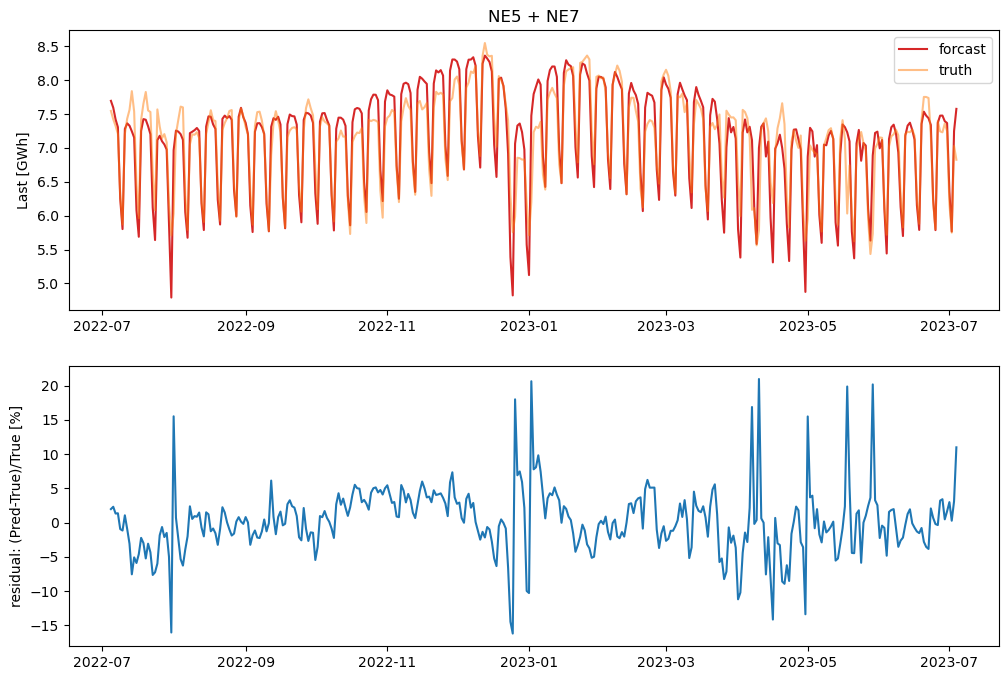

In [ ]:
f, axes = plt.subplots(2, 1, figsize=(12, 8))


axes[0].plot(y_pred, color="tab:red", label="forecast")
# axes[0].plot(pdfTrain.ds.values, pdfTrain.y.values, color="tab:blue", label="train")
axes[0].plot(pdf_test, color="tab:orange", label="truth", alpha=0.5)
axes[0].legend()
axes[0].set_title("NE5 + NE7")
axes[0].set_ylabel("Last [GWh]")


xmin, xmax = axes[0].get_xlim()

axes[1].plot(pdf_test.index, (y_pred.values - pdf_test.y.values) / (pdf_test.y.values)*100)
axes[1].set_xlim(xmin, xmax)
axes[1].set_ylabel("residual: (Pred-True)/True [%]")

plt.show()

In [ ]:
print(f"RMSE: {mean_squared_error(y_pred, pdf_test.y.values, squared=False)}")


RMSE: 0.3147531000136021


In [ ]:
# Wow this is really good!

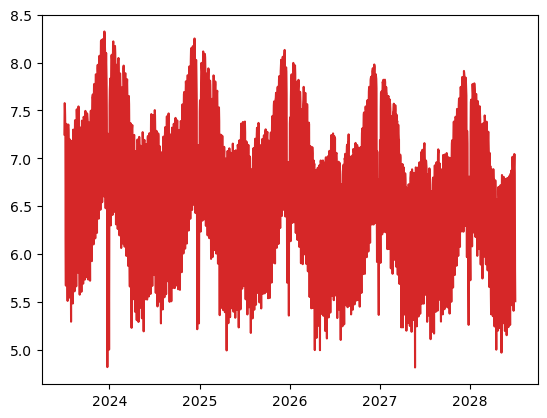

In [8]:
#create a series with time stamps from 2023-07-03 to 2028-07-02
fh = ForecastingHorizon(pd.date_range(start='2023-07-03', end='2028-07-02', freq='D'), is_relative=False)

y_pred  = forecaster.predict(fh=fh)

plt.plot(y_pred, color="tab:red", label="forecast")